In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter # model to smooth noisy inputs

import pandas as pd

In [5]:
def normalize_data(df, columns):
    for column in columns:
        mean_value = df.loc[:,column].mean()
        stdev = np.std(df.loc[:,column].values)
        df.loc[:,column] = (df.loc[:,column] - mean_value) / stdev
    return df

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden


In [3]:
def train(rnn, n_steps, print_every):

    # initialize the hidden state
    hidden = None

    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data
        input_data = np.nan_to_num(df_train_inputs.values.astype(float))
        target = np.nan_to_num(df_train_targets.values.astype(float))

        x = input_data
        y = target

        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i % print_every == 0:
            print('Loss: ', loss.item())

            fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
            fig.set_size_inches(15, 3)
            ax = axs[0]
            ax.plot(range(140), target[:, 0].flatten(), 'r.')  # input
            ax.plot(range(140), prediction.data.numpy()[:, 0].flatten(), 'b.')  # predictions

            ax = axs[1]
            ax.plot(range(140), target[:, 1].flatten(), 'r.')  # input
            ax.plot(range(140), prediction.data.numpy()[:, 1].flatten(), 'b.')  # predictions

            plt.show()

    return rnn, hidden


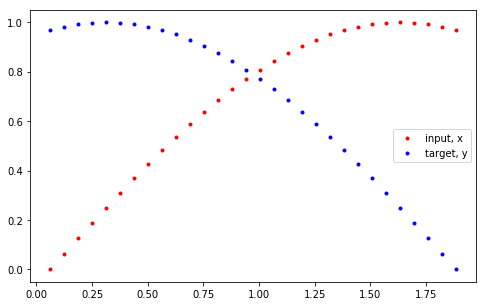

In [25]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 50

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:30] # all but the last piece of data
y = data[-30:] # all but the first

# display the data
plt.plot(time_steps[1:31], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:31], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [6]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [11]:
seq_length = 50

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first


In [16]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
#         time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
#         data = np.sin(time_steps)
#         data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:30]
        y = data[-30:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:31], data[:30], 'r.') # input
            plt.plot(time_steps[1:31], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.004924736451357603


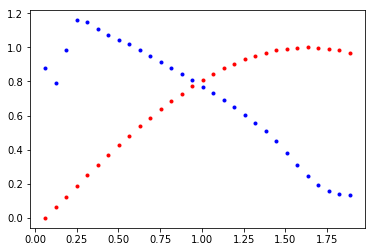

Loss:  0.0006087900837883353


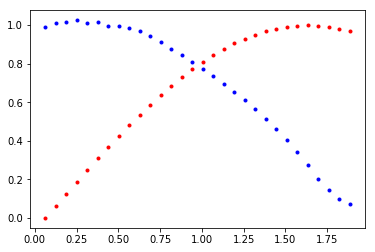

Loss:  0.00014857474889140576


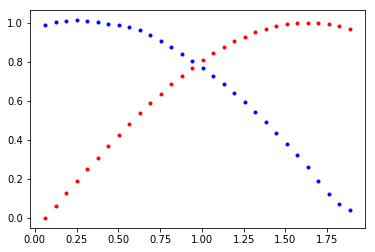

Loss:  0.0004589261079672724


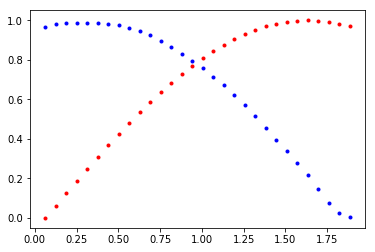

Loss:  8.39006679598242e-05


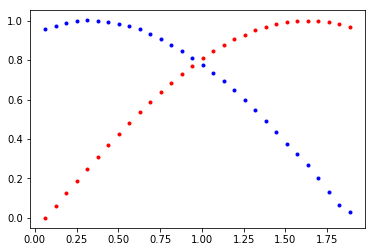

In [26]:
# train the rnn and monitor results
n_steps = 750
print_every = 150

trained_rnn = train(rnn, n_steps, print_every)

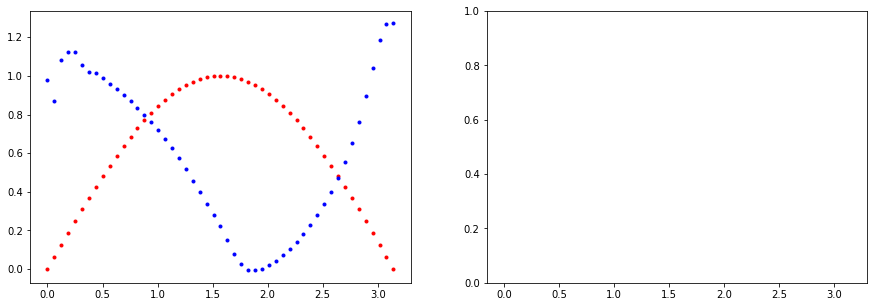

In [27]:
seq_length = 50

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data # all but the last piece of data
# y = data[1:] # all but the first


# convert data into Tensors
x_tensor = torch.Tensor(x).unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension
# y_tensor = torch.Tensor(y)

# hidden = None
trained_rnn.eval()
pre_hidden = None
prediction, hidden = trained_rnn(x_tensor, pre_hidden)

## Representing Memory ##
# make a new variable for hidden and detach the hidden state from its history
# this way, we don't backpropagate through the entire history

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15, 5)
ax = axs[0]
ax.plot(time_steps, x, 'r.')  # input
ax.plot(time_steps, prediction.data.numpy()[:, 0].flatten(), 'b.')  # predictions

plt.show()